In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using PhasorNetworks

In [3]:
using Plots

[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


In [4]:
using LinearAlgebra: triu, diagm, diag

In [5]:
using Statistics: std, median

In [6]:
using QuadGK

In [7]:
using Random: Xoshiro, AbstractRNG

# Construct a random graph

In [8]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e)

In [9]:
function generate_er_graph(n::Int, p::Real, rng::AbstractRNG, self_loops::Bool = false)
    adj = rand(rng, Float64, (n, n)) .< p
    #make undirected
    adj = triu(adj)
    adj =  (adj .+ adj') .> 0

    if !self_loops
        #remove self-loops
        for i in 1:n
            adj[i,i] = 0
        end
    end

    return adj
end

generate_er_graph (generic function with 2 methods)

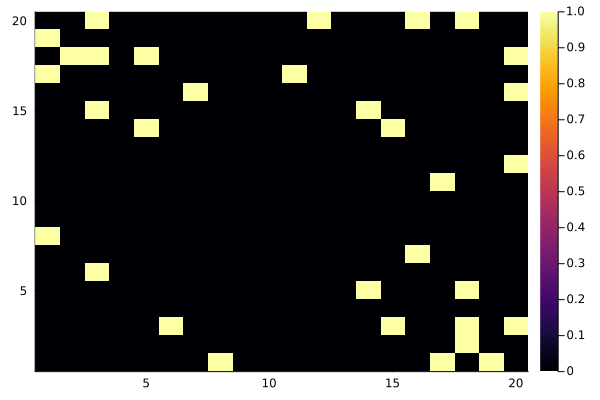

In [10]:
g1 = generate_er_graph(20, 0.1, rng)
heatmap(g1)

# Embed it into an HD vector

In [11]:
function define_node_symbols(graph::AbstractMatrix, nd::Int, rng::AbstractRNG)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)

    #create vectors representing the nodes
    node_values = random_symbols((n, nd), rng)
    return node_values
end

define_node_symbols (generic function with 1 method)

In [12]:
nv1 = define_node_symbols(g1, 1024, rng);

In [13]:
size(nv1)

(20, 1024)

In [14]:
function graph_to_vector(graph::AbstractMatrix, node_values::AbstractMatrix)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)
    nd = size(node_values, 2)

    #get cartesian coordinates representing each edge
    edges = findall(graph)
    n_edges = length(edges)
    edge_values = zeros(Float64, n_edges, nd)

    #iterate through the edges
    for (i, edge) in enumerate(edges)
        tx = edge[1]
        rx = edge[2]

        tx_symbol = node_values[tx,:]
        rx_symbol = node_values[rx,:]
        #create a representation for that edge by binding its incident nodes
        edge_symbol = v_bind(tx_symbol, rx_symbol)
        edge_values[i,:] = edge_symbol
    end

    #DEBUG
    #return edge_values
    #combine the edges in the graph to the single embedding via bundling
    graph_embedding = v_bundle(edge_values, dims=1)
    return edge_values, graph_embedding
end

graph_to_vector (generic function with 1 method)

In [15]:
#ev1 = graph_to_vector(g1, nv1)
ev1, gv1 = graph_to_vector(g1, nv1)

([0.2824137210845947 -0.3788365125656128 … 0.31351935863494873 0.5788869857788086; 0.5679284334182739 0.8651573657989502 … -0.06556212902069092 -0.2388221025466919; … ; 0.27909743785858154 0.07673704624176025 … 0.7631732225418091 0.9447349309921265; 0.6442599296569824 0.447174072265625 … -0.6502662897109985 0.09361386299133301], [0.8452598372705079 -0.6859352585442474 … -0.0367162431035466 0.9752866616929428])

In [79]:
sa = SpikingArgs(threshold=0.001, solver_args=Dict(:adaptive => false, :dt => 0.005))

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [80]:
function graph_to_vector(graph::AbstractMatrix, node_values::AbstractMatrix, spk_args::SpikingArgs; repeats::Int=5)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)
    nd = size(node_values, 2)
    
    #slice each node symbol into a spike train
    train_values = [phase_to_train(reshape(node, (1,:)), spk_args=spk_args, repeats=repeats) for node in eachslice(node_values, dims=1)]
    tspan = (0.0, repeats * 1.0)
    
    #get cartesian coordinates representing each edge
    edges = findall(graph)
    n_edges = length(edges)
    edge_values = []

    #iterate through the edges
    function edge_to_train(edge)
        tx = edge[1]
        rx = edge[2]

        tx_symbol = train_values[tx]
        rx_symbol = train_values[rx]
        #create a representation for that edge by binding its incident nodes
        edge_symbol = v_bind(tx_symbol, rx_symbol, spk_args=spk_args, tspan=tspan)
        return edge_symbol
    end

    edge_values = map(edge_to_train, edges)
    #combine the edges in the graph to the single embedding via bundling
    combined = vcat_trains(edge_values)
    graph_embedding = v_bundle(combined, dims=1, spk_args=spk_args, tspan=tspan)
    return train_values, edge_values, graph_embedding, tspan
end

graph_to_vector (generic function with 2 methods)

In [81]:
#tv1, evt1 = graph_to_vector(g1, nv1, sa, repeats=5)
nvt1, evt1, gvt1, tspan = graph_to_vector(g1, nv1, sa, repeats=5)

(SpikeTrain[Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes.], SpikeTrain[Spike Train: (1, 1024) with 4669 spikes., Spike Train: (1, 1024) with 4651 spikes., Spike Train: (1, 1024) with 4663 spikes., Spike Trai

In [82]:
evt1[1].offset

0.25

In [83]:
gvt1.offset

0.5

In [84]:
function shift_time(x::SpikeTrain, t::Real)
    return SpikeTrain(x.indices, x.times, x.shape, x.offset + t)
end

shift_time (generic function with 1 method)

In [85]:
edgeval = train_to_phase(shift_time(evt1[1], -0.0), sa);

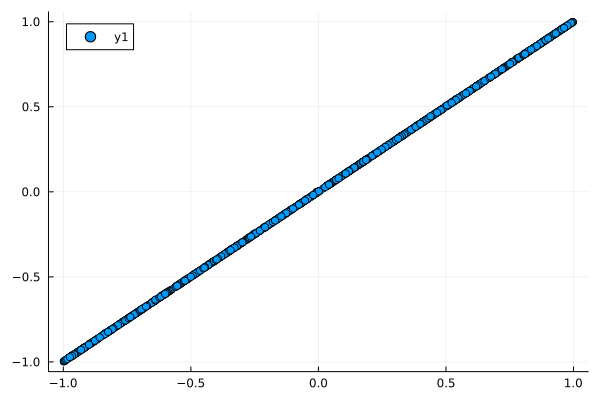

In [86]:
scatter(edgeval[end-1,1,:], ev1[1,:])

In [87]:
p2 = train_to_phase(shift_time(gvt1, 0.0), sa);

In [88]:
size(p2)

(6, 1, 1024)

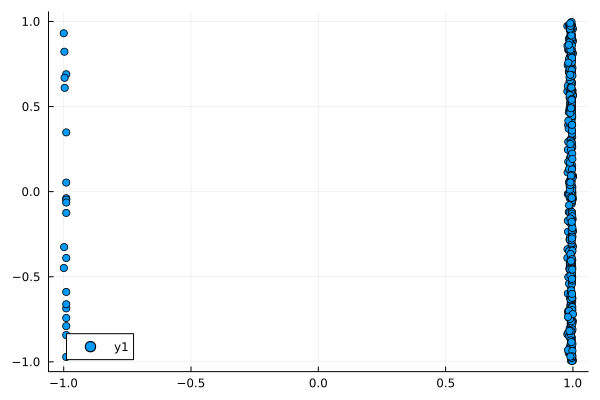

In [89]:
scatter(p2[2,1,:], vec(gv1))

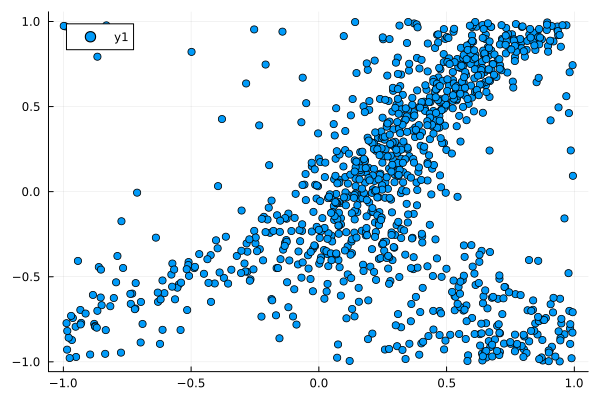

In [90]:
scatter(p2[3,1,:], vec(gv1))

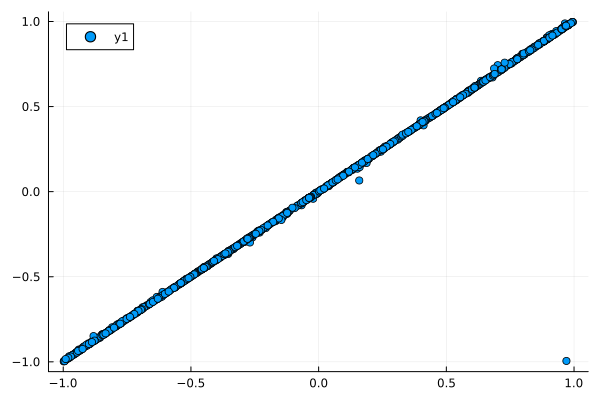

In [91]:
scatter(p2[4,1,:], vec(gv1))

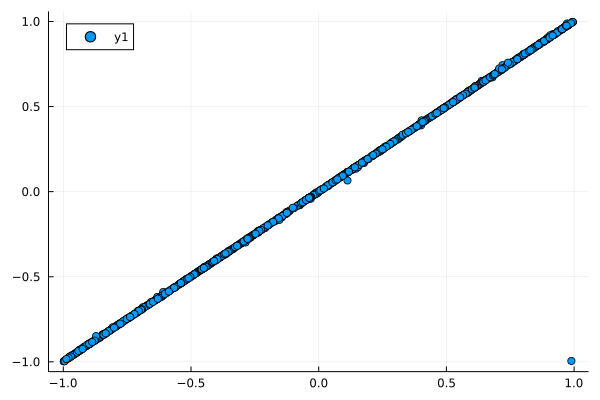

In [92]:
scatter(p2[5,1,:], vec(gv1))

In [93]:
ss = similarity(gv1, zero_nans(p2[end-1,1:1,:]), dim=1)

1×1024 Matrix{Float64}:
 0.999994  0.999911  0.999983  0.999979  …  0.999996  0.999994  0.99987

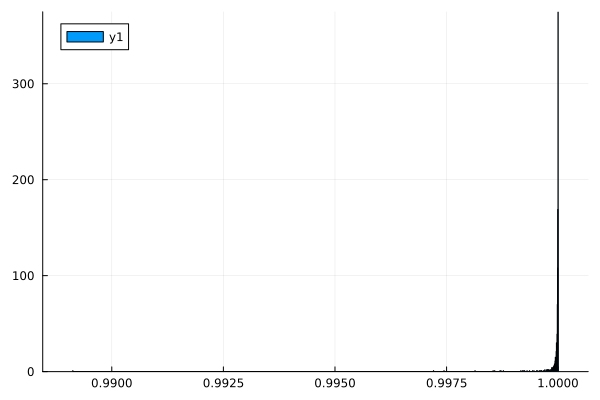

In [94]:
histogram(ss |> vec)

In [95]:
median(ss)

0.999991288431467

# Use similarity to reconstruct the graph

In [96]:
function query_edges(graph::AbstractMatrix, nodes::AbstractMatrix)
    n = size(nodes, 1)
    nd = size(graph, 2)

    adj_rec = zeros(Float64, n, n)
    for (i,node) in enumerate(eachslice(nodes, dims=1))
        #add a dimension for consistency
        node = reshape(node, (1, :))
        query = v_unbind(graph, node)
        s = similarity_outer(query, nodes, dims=1) |> vec
        adj_rec[i,:] = s
    end

    return adj_rec
end

query_edges (generic function with 2 methods)

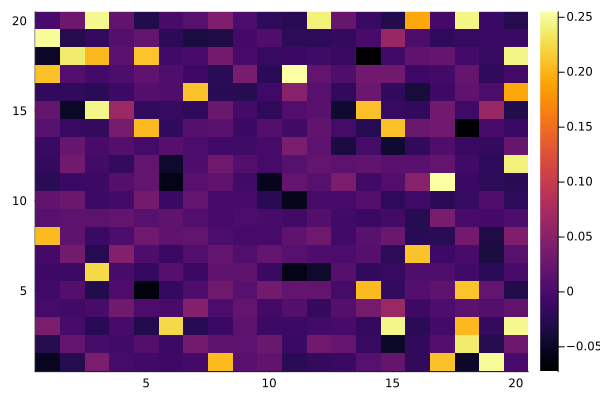

In [97]:
rec1 = query_edges(gv1, nv1)
heatmap(rec1)

In [98]:
function query_edges(graph::SpikeTrain, nodes::Vector{<:SpikeTrain}, spk_args::SpikingArgs, tspan::Tuple{<:Real, <:Real})
    all_nodes = vcat_trains(nodes)
    
    function query_edge(node)
        query = v_unbind(graph, node, tspan=tspan, spk_args=spk_args)
        s = similarity_outer(query, all_nodes, dims=1, reduce_dim=2, spk_args=spk_args, tspan=tspan)
        return s
    end
    
    similarity = map(query_edge, nodes)
    adj_rec = stack(map(x -> last.(x), similarity))[1,:,:]

    return adj_rec
end

query_edges (generic function with 2 methods)

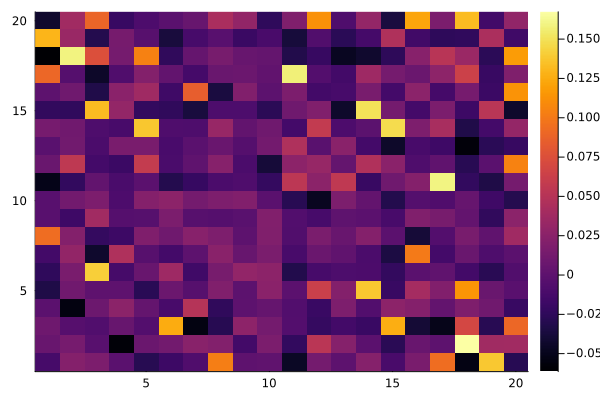

In [108]:
rec2 = query_edges(gvt1, nvt1, sa, tspan)
heatmap(rec2)

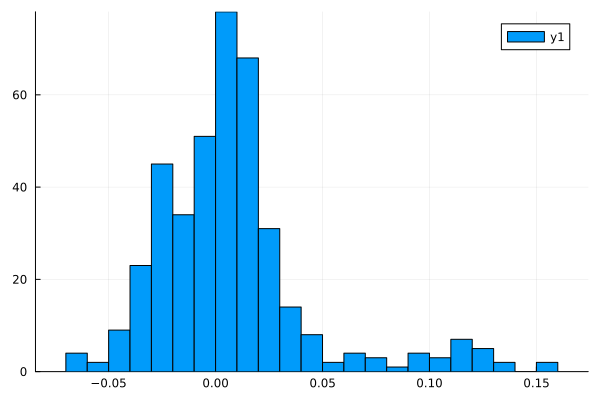

In [109]:
histogram((rec1 .- rec2)|> vec)

# Determine the quality of the reconstruction (AUROC)

In [110]:
function auroc(graph::AbstractMatrix, reconstruction::AbstractMatrix)
    tpr, fpr = tpr_fpr(vec(reconstruction), vec(graph))
    roc_fn = interpolate_roc((tpr, fpr))
    auc, err = quadgk(x -> roc_fn(x), 0.0, 1.0)
    return auc, err
end

auroc (generic function with 1 method)

In [111]:
auroc(g1, rec1)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    403-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/91PhN/src/gridded/gridded.jl:77


(1.0, 0.0)

In [112]:
auroc(g1, rec2)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    403-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/91PhN/src/gridded/gridded.jl:77


(1.0, 0.0)

In [113]:
auroc(g1, rand(rng, Float32, size(rec2)))

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    403-element Vector{Float64}:
│     0.0
│     0.06793478260869565
│     0.16032608695652173
│     0.2391304347826087
│     0.32608695652173914
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/91PhN/src/gridded/gridded.jl:77


(0.575959582829452, 7.920927685728819e-9)

In [114]:
tpr, fpr = tpr_fpr(vec(rec1), vec(g1))

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

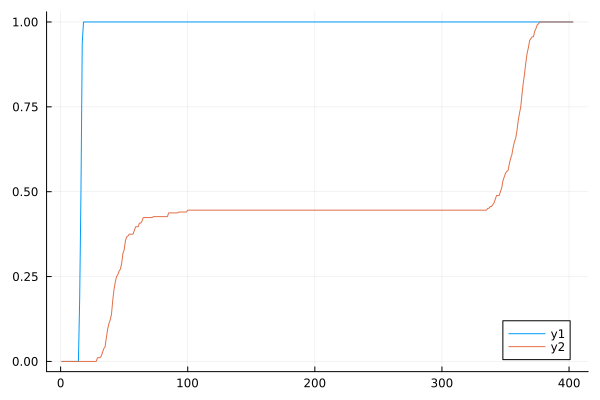

In [115]:
plot(tpr)
plot!(fpr)

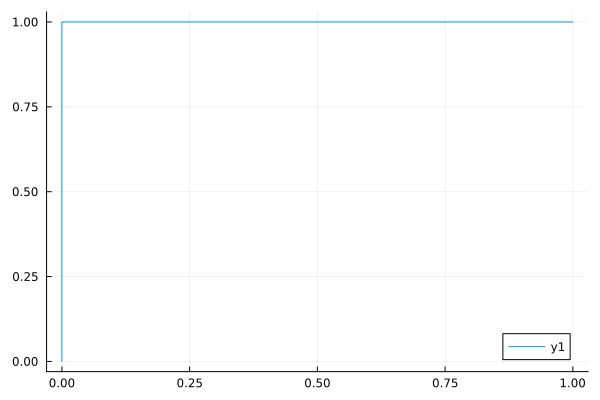

In [117]:
plot(fpr, tpr)

In [118]:
roc = interpolate_roc((tpr, fpr));

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    403-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/91PhN/src/gridded/gridded.jl:77


In [119]:
quadgk(x -> roc(x), 0.0, 1.0)

(1.0, 0.0)

In [120]:
tpr2, fpr2 = tpr_fpr(vec(rec2), vec(g1))

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

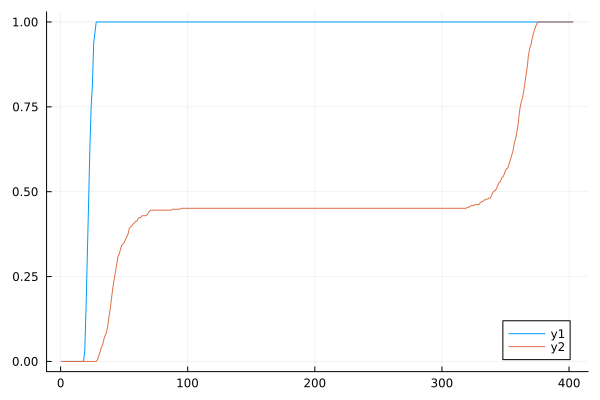

In [121]:
plot(tpr2)
plot!(fpr2)

In [122]:
quadgk(x -> interpolate_roc((tpr2, fpr2))(x), 0.0, 1.0)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    403-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/91PhN/src/gridded/gridded.jl:77


(1.0, 0.0)